In [136]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from scipy.stats import norm, skewnorm
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*pstrainFilt*")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')


Params for this run:
	Mc = 1.6
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_pstrainFilt_0005.h5', 'shearlayer_pstrainFilt_0006.h5', 'shearlayer_pstrainFilt_0007.h5', 'shearlayer_pstrainFilt_0008.h5', 'shearlayer_pstrainFilt_0009.h5', 'shearlayer_pstrainFilt_0010.h5', 'shearlayer_pstrainFilt_0011.h5', 'shearlayer_pstrainFilt_0012.h5']


In [146]:
# correlation coeff
def get_corrcoef(flist,key1,key2):
    mat = np.zeros([len(flist),1])
    for i,f in enumerate(flist):
        hf = h5py.File(f, 'r')
        dat1=hf[key1]
        dat2=hf[key2]
        itop = Ny/2-1
        ibot = Ny/2+1
        dat1 = np.array(dat1[:,Ny/2,:]).flatten()
        dat2 = np.array(dat2[:,Ny/2,:]).flatten()
        Cij = np.corrcoef(dat1,dat2)
        mat[i,0] = Cij[0][1]
        hf.close()

    return mat

#mat = get_corrcoef(flist[1:])
#print(np.mean(mat[:,0]),np.std(mat[:,0]))

# plt.plot(dat1,dat2,'*',alpha=0.1)
# plt.grid(True)

In [147]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    
    flist = glob.glob(directory+"*pstrainFilt*")
    flist.sort()
    mat = get_corrcoef(flist,'P11','P22')
    print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[:,0]),np.std(mat[:,0])))


0.2: [-0.325440833269,0.0498949388664],
0.4: [-0.279936509597,0.0756851290991],
0.8: [-0.33355196726,0.114896960384],
1.2: [-0.319792914273,0.0391386371029],
1.6: [-0.392323169853,0.0789546846894],
2.0: [-0.352551034846,0.0536750400352],


<Figure size 750x450 with 0 Axes>

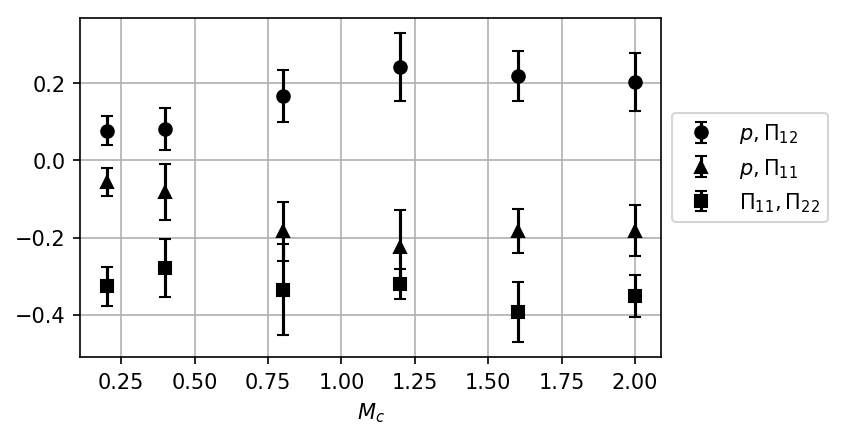

In [153]:
p_p12 = {
0.2: [0.0765043390428,0.0372985858908],
0.4: [0.081331552286,0.0545091525148],
0.8: [0.16692730231,0.0669119361032],
1.2: [0.241306320619,0.0884130451885],
1.6: [0.218595055549,0.0654798485188],
2.0: [0.202497136437,0.0750481495561],
}
p_p11 = {
0.2: [-0.0565973181687,0.036927428586],
0.4: [-0.0816888433804,0.0717428196541],
0.8: [-0.183750356671,0.0767694299671],
1.2: [-0.225179569182,0.0953210764552],
1.6: [-0.183130733693,0.0561154976261],
2.0: [-0.181943032024,0.0663601726301],
}
p11_p22 = {
0.2: [-0.32639100817,0.0510155633616],
0.4: [-0.279244493032,0.0742337933348],
0.8: [-0.33532249782,0.118309942761],
1.2: [-0.32027324875,0.0382055351842],
1.6: [-0.392893989297,0.0780497516769],
2.0: [-0.352403195843,0.0541715194417],
}

def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(5,3),dpi=150)
plotter(p_p12,'ko','$p,\Pi_{12}$')
plotter(p_p11,'k^','$p,\Pi_{11}$')
plotter(p11_p22,'ks','$\Pi_{11},\Pi_{22}$')


plt.xlabel('$M_c$')
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 0.75))

(1024, 512)
(1024,)


(1e-10, 100.0)

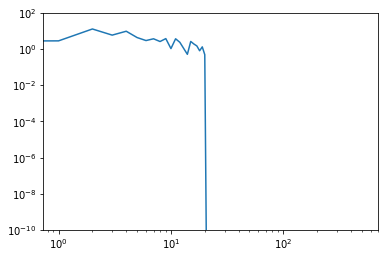

In [65]:
f=hf['p']
xdir = 0
zdir = 1
fhat = np.fft.fft(f[:,Ny/2,:],axis=xdir)
print(np.shape(fhat))
fhat = np.mean(fhat,axis=zdir)
print(np.shape(fhat))

plt.loglog(np.abs(fhat[:Nx/2]))
plt.ylim([1e-10,1e2])

Reading and normalizing data
0/8
1/8
2/8
3/8
4/8
5/8
6/8
7/8
Fitting data
Getting histogram


/gpfs/mira-home/kmatsuno/floatpy_env/lib/python2.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


Adding best fit line
/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512//PDF_p


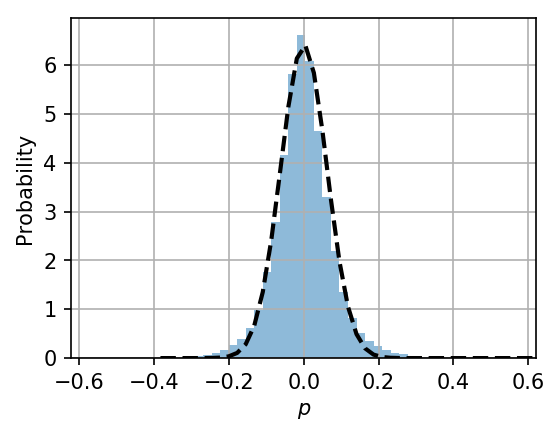

/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512//img/PDF_p.png


<Figure size 432x288 with 0 Axes>

In [134]:
def plot_pdf(flist):
    datos = np.zeros([Nx,Nz,len(flist)])

    print('Reading and normalizing data')
    for i,f in enumerate(flist):
        print('{}/{}'.format(i,len(flist)))
        hf = h5py.File(f, 'r')
        p = hf['p']
        dat = p[:,Ny/2,:]
        datos[:,:,i] = dat#/np.std(dat.flatten())
        hf.close()
    datos = datos.flatten()

    # best fit of data
    print('Fitting data')
    (mu, sigma) = norm.fit(datos)
    if inp.Mc==1.6: sigma *=0.8
    
    # the histogram of the data
    print('Getting histogram')
    plt.figure(figsize=(4,3),dpi=150)
    n, bins, patches = plt.hist(datos, bins=50,density=True,alpha=0.5)

    # add a 'best fit' line
    print('Adding best fit line')
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'k--', linewidth=2)

    # save for later
    savename = directory+'/PDF_p'
    np.savez(savename, bins=bins, pdf=y)
    print(savename)

    #plot
    plt.xlabel(r"$p$")
    plt.ylabel('Probability')
    plt.xlim([-10*sigma,10*sigma])
    plt.grid(True)
    plt.show()
    
    
plot_pdf(flist[:])
savename = directory+'/img/PDF_p.png'
plt.savefig(savename,dpi=200,bbox_inches='tight')
print(savename)

(-0.4, 0.4)

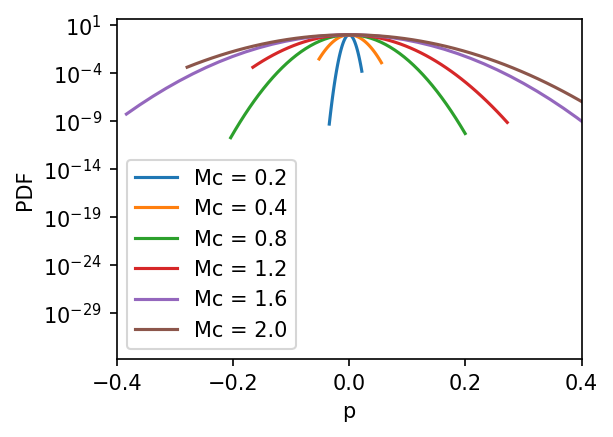

In [154]:
Mc_list = ['02','04','08','12','16','20']

fig = plt.figure(figsize=(4,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)

    #flist = glob.glob(directory+"*pstrainFilt*")
    #flist.sort()
    #plot_pdf(flist[:])
    
    flist = glob.glob(directory+"*PDF_p*")
    dat = np.load(flist[0])
    pdf = dat['pdf']
    plt.semilogy(dat['bins'],pdf/np.amax(pdf),label='Mc = {}'.format(inp.Mc))

plt.legend()
plt.xlabel('p')
plt.ylabel('PDF')
plt.xlim([-0.4,0.4])